In [1]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx

In [2]:
def save(model, path):
    eqx.tree_serialise_leaves(path, model)
    #with open(path, 'wb') as fp:
    #    pickle.dump(model, fp)

def load(path):
    return eqx.tree_deserialise_leaves(path, model)

In [3]:

class MixerBlock(eqx.Module):
    patch_mixer: eqx.nn.MLP
    hidden_mixer: eqx.nn.MLP
    norm1: eqx.nn.LayerNorm
    norm2: eqx.nn.LayerNorm

    def __init__(
        self, num_patches, hidden_size, mix_patch_size, mix_hidden_size, *, key
    ):
        tkey, ckey = jr.split(key, 2)
        self.patch_mixer = eqx.nn.MLP(
            num_patches, num_patches, mix_patch_size, depth=1, key=tkey
        )
        self.hidden_mixer = eqx.nn.MLP(
            hidden_size, hidden_size, mix_hidden_size, depth=1, key=ckey
        )
        self.norm1 = eqx.nn.LayerNorm((hidden_size, num_patches))
        self.norm2 = eqx.nn.LayerNorm((num_patches, hidden_size))

    def __call__(self, y):
        y = y + jax.vmap(self.patch_mixer)(self.norm1(y))
        y = einops.rearrange(y, "c p -> p c")
        y = y + jax.vmap(self.hidden_mixer)(self.norm2(y))
        y = einops.rearrange(y, "p c -> c p")
        return y

class Mixer2d(eqx.Module):
    conv_in: eqx.nn.Conv2d
    conv_out: eqx.nn.ConvTranspose2d
    blocks: list
    norm: eqx.nn.LayerNorm
    t1: float

    def __init__(
        self,
        img_size,
        patch_size,
        hidden_size,
        mix_patch_size,
        mix_hidden_size,
        num_blocks,
        t1,
        *,
        key,
    ):
        input_size, height, width = img_size
        assert (height % patch_size) == 0
        assert (width % patch_size) == 0
        num_patches = (height // patch_size) * (width // patch_size)
        inkey, outkey, *bkeys = jr.split(key, 2 + num_blocks)

        self.conv_in = eqx.nn.Conv2d(
            input_size + 1, hidden_size, patch_size, stride=patch_size, key=inkey
        )
        self.conv_out = eqx.nn.ConvTranspose2d(
            hidden_size, input_size, patch_size, stride=patch_size, key=outkey
        )
        self.blocks = [
            MixerBlock(
                num_patches, hidden_size, mix_patch_size, mix_hidden_size, key=bkey
            )
            for bkey in bkeys
        ]
        self.norm = eqx.nn.LayerNorm((hidden_size, num_patches))
        self.t1 = t1

    def __call__(self, t, y):
        t = t / self.t1
        _, height, width = y.shape
        t = einops.repeat(t, "-> 1 h w", h=height, w=width)
        y = jnp.concatenate([y, t])
        y = self.conv_in(y)
        _, patch_height, patch_width = y.shape
        y = einops.rearrange(y, "c h w -> c (h w)")
        for block in self.blocks:
            y = block(y)
        y = self.norm(y)
        y = einops.rearrange(y, "c (h w) -> c h w", h=patch_height, w=patch_width)
        return self.conv_out(y)

def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)


def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))


@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1, adjoint=dfx.NoAdjoint())
    return sol.ys[0]

def mnist():
    filename = "train-images-idx3-ubyte.gz"
    url_dir = "https://storage.googleapis.com/cvdf-datasets/mnist"
    target_dir = os.getcwd() + "/data/mnist"
    url = f"{url_dir}/{filename}"
    target = f"{target_dir}/{filename}"

    if not os.path.exists(target):
        os.makedirs(target_dir, exist_ok=True)
        urllib.request.urlretrieve(url, target)
        print(f"Downloaded {url} to {target}")

    with gzip.open(target, "rb") as fh:
        _, batch, rows, cols = struct.unpack(">IIII", fh.read(16))
        shape = (batch, 1, rows, cols)
        return jnp.array(array.array("B", fh.read()), dtype=jnp.uint8).reshape(shape)
    
    
def fashion_mnist():
    filename = "train-images-idx3-ubyte.gz"
    url_dir = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com"
    target_dir = os.getcwd() + "/data/fasion_mnist"
    url = f"{url_dir}/{filename}"
    target = f"{target_dir}/{filename}"

    if not os.path.exists(target):
        os.makedirs(target_dir, exist_ok=True)
        urllib.request.urlretrieve(url, target)
        print(f"Downloaded {url} to {target}")

    with gzip.open(target, "rb") as fh:
        _, batch, rows, cols = struct.unpack(">IIII", fh.read(16))
        shape = (batch, 1, rows, cols)
        return jnp.array(array.array("B", fh.read()), dtype=jnp.uint8).reshape(shape)


def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm]
            start = end
            end = start + batch_size


@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state

In [7]:
patch_size=4
hidden_size=64
mix_patch_size=512
mix_hidden_size=512
num_blocks=4
t1=10.0
# Optimisation hyperparameters
num_steps=1_000_000
lr=3e-4
batch_size=256
print_every=10_000
# Sampling hyperparameters
dt0=0.1
sample_size=10
# Seed
seed=5678

key = jr.PRNGKey(seed)
model_key, train_key, loader_key, sample_key = jr.split(key, 4)
data = fashion_mnist()
data_mean = jnp.mean(data)
data_std = jnp.std(data)
data_max = jnp.max(data)
data_min = jnp.min(data)
data_shape = data.shape[1:]
data = (data - data_mean) / data_std

model = Mixer2d(
    data_shape,
    patch_size,
    hidden_size,
    mix_patch_size,
    mix_hidden_size,
    num_blocks,
    t1,
    key=model_key,
)
int_beta = lambda t: t  # Try experimenting with other options here!
weight = lambda t: 1 - jnp.exp(
    -int_beta(t)
)  # Just chosen to upweight the region near t=0.

In [ ]:
opt = optax.adabelief(lr)
# Optax will update the floating-point JAX arrays in the model.
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

total_value = 0
total_size = 0
for step, data in zip(
    range(num_steps), dataloader(data, batch_size, key=loader_key)
):
    value, model, train_key, opt_state = make_step(
        model, weight, int_beta, data, t1, train_key, opt_state, opt.update
    )
    total_value += value.item()
    total_size += 1
    if (step % print_every) == 0 or step == num_steps - 1:
        print(f"Step={step} Loss={total_value / total_size}")
        total_value = 0
        total_size = 0

sample_key = jr.split(sample_key, sample_size**2)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)
sample = data_mean + data_std * sample
sample = jnp.clip(sample, data_min, data_max)
sample = einops.rearrange(
    sample, "(n1 n2) 1 h w -> (n1 h) (n2 w)", n1=sample_size, n2=sample_size
)
plt.imshow(sample, cmap="Greys")
plt.axis("off")
plt.tight_layout()
plt.show()

#### Model available here:  https://www.dropbox.com/s/n18eljf0bzckmop/kidger_model.jax?dl=0

In [4]:
path = './kidger_model.jax'

In [5]:
#save(model, path)

In [8]:
model = load(path)

/home/jason/anaconda3/envs/kidger/lib/python3.10/site-packages/diffrax/integrate.py:83: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  [ts, save_index] + jax.tree_leaves(ys),
/home/jason/anaconda3/envs/kidger/lib/python3.10/site-packages/diffrax/integrate.py:81: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  lambda s: [s.ts, s.save_index] + jax.tree_leaves(s.ys),


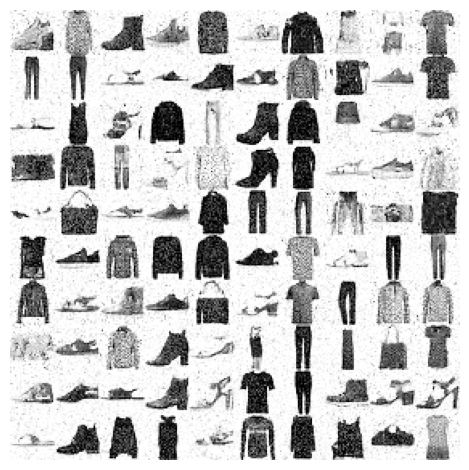

In [10]:
t1=15.0
sample_size=10
model_key, train_key, loader_key, sample_key = jr.split(key, 4)
sample_key = jr.split(sample_key, sample_size**2)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)
sample = data_mean + data_std * sample
sample = jnp.clip(sample, data_min, data_max)
sample = einops.rearrange(
    sample, "(n1 n2) 1 h w -> (n1 h) (n2 w)", n1=sample_size, n2=sample_size
)
plt.imshow(sample, cmap="Greys")
plt.axis("off")
plt.tight_layout()
plt.show()